In [23]:

#Importing all the relevant library
%matplotlib inline
import h5py, os
#from functions import transforms as T
#from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
import numpy as np
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import glob
#from functions import transforms as T 
#from functions.subsample import MaskFunc
from PIL import Image
import random
from numpy.fft import fftshift, ifftshift, fftn, ifftn
import cmath

In [2]:
import torchvision.transforms as transforms

In [3]:
import numpy as np
from numpy.fft import fftshift, ifftshift, fftn, ifftn

def transform_kspace_to_image(k, dim=None, img_shape=None):
    """ Computes the Fourier transform from k-space to image space
    along a given or all dimensions
    :param k: k-space data
    :param dim: vector of dimensions to transform
    :param img_shape: desired shape of output image
    :returns: data in image space (along transformed dimensions)
    """
    if not dim:
        dim = range(k.ndim)

    img = fftshift(ifftn(ifftshift(k, axes=dim), s=img_shape, axes=dim), axes=dim)
    #img = fftshift(ifft2(ifftshift(k, dim=dim)), dim=dim)
    img *= np.sqrt(np.prod(np.take(img.shape, dim)))
    return img


def transform_image_to_kspace(img, dim=None, k_shape=None):
    """ Computes the Fourier transform from image space to k-space space
    along a given or all dimensions
    :param img: image space data
    :param dim: vector of dimensions to transform
    :param k_shape: desired shape of output k-space data
    :returns: data in k-space (along transformed dimensions)
    """
    if not dim:
        dim = range(img.ndim)

    k = fftshift(fftn(ifftshift(img, axes=dim), s=k_shape, axes=dim), axes=dim)
    #k = fftshift(fft2(ifftshift(img, dim=dim)), dim=dim)
    k /= np.sqrt(np.prod(np.take(img.shape, dim)))
    return k

In [4]:

def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

In [5]:
class MRIDataset(DataLoader):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]

        return get_epoch_batch(subject_id)

In [6]:
import random
import numpy as np
from numpy.fft import fftshift, ifftshift, fftn, ifftn
import cmath
def noise_and_kspace(image):
    #change to k-space
    img_fft = fftshift(fftn(image))
    size_img = img_fft.shape
     #np.random.uniform, np.random.normal
    std = np.random.normal(0.000, 0.005) * np.amax(img_fft)
    noise = fftshift(std * np.random.standard_normal(size_img) + std * 1j * np.random.standard_normal(size_img));     #This generates a complex noise signal.
    img_fft_noise = img_fft + noise # k-space
    img_noise = ifftn(ifftshift(img_fft_noise))# revert k-space back to noise
    return img_noise

In [7]:
def get_epoch_batch(subject_id):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name = subject_id  
    
#    with h5py.File(rawdata_name, 'r') as data:
#        rawdata = data['kspace'][slice]
   
    im_frame = Image.open(rawdata_name)
    noise_im_frame = noise_and_kspace(im_frame)

    ############################
    #img_und = to_tensor(np.array(noise_im_frame)).unsqueeze(0) # noise image tensor form    
    preprocess = T.Compose([
                       # T.Grayscale(num_output_channels=1),
                           T.Resize(64),    #128 as maximum #64
                           T.CenterCrop(64),
                           T.ToTensor() #,
                            ])
    img_gt = preprocess(Image.fromarray(np.uint8(im_frame)).convert('L'))
    img_und = preprocess(Image.fromarray(np.uint8(noise_im_frame)).convert('L'))
    
    n1 = (img_und**2).sum(dim=-1).sqrt()
    norm = n1.max() 
    if norm < 1e-6: norm = 1e-6
    
    img_gt, img_und = img_gt/norm , img_und/norm

    return img_gt.squeeze(0), img_und.squeeze(0)

In [8]:
def load_data_path(train_data_path, val_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_and_val = ['train', 'val']
    data_path = [train_data_path, val_data_path]
      
    for i in range(len(data_path)):

        data_list[train_and_val[i]] = []
        
        which_data_path = data_path[i]
        tr = 0
        te = 0
        alfa = 0
    
        for fname in sorted(os.listdir(which_data_path)):
            if fname == '.DS_Store': continue
            
            subject_data_path = os.path.join(which_data_path, fname)
                     
            if not os.path.isfile(subject_data_path): continue 
            
     
            #get information from text file
            # this will return a tuple of root and extension
            split_tup = os.path.splitext(fname)

  
            # extract the file name and extension
            file_name = split_tup[0]
  
                
            # the first 5 slices are mostly noise so it is better to exlude them
            data_list[train_and_val[i]].append((fname, subject_data_path))
    
    return data_list

# RestNet

In [9]:
class baseBlock(torch.nn.Module):
    expansion = 1
    def __init__(self,input_planes,planes,stride=1,dim_change=None):
        super(baseBlock,self).__init__()
        #declare convolutional layers with batch norms
        self.conv1 = torch.nn.Conv2d(input_planes,planes,stride=stride,kernel_size=3,padding=1)
        self.bn1   = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes,planes,stride=1,kernel_size=3,padding=1)
        self.bn2   = torch.nn.BatchNorm2d(planes)
        self.dim_change = dim_change
    def forward(self,x):
        #Save the residue
        res = x
        output = F.relu(self.bn1(self.conv1(x)))
        output = self.bn2(self.conv2(output))
        if self.dim_change is not None:
            res = self.dim_change(res)
        
        output += res
        output = F.relu(output)

        return output

class ResNet(torch.nn.Module):
    def __init__(self,block,num_layers,classes=10):
        super(ResNet,self).__init__()
        #according to research paper:
        self.input_planes = 64 #256
        self.conv1 = torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1)
        self.layer1 = self._layer(block,64,num_layers[0],stride=1)
        self.layer2 = self._layer(block,64,num_layers[1],stride=1)
        self.layer3 = self._layer(block,64,num_layers[2],stride=1)
        self.layer4 = self._layer(block,64,num_layers[3],stride=1)
        self.layer5 = self._layer(block,64,num_layers[3],stride=1)
        self.layer6 = self._layer(block,64,num_layers[3],stride=1)
        self.layer7 = self._layer(block,64,num_layers[3],stride=1)
        self.layer8 = self._layer(block,64,num_layers[2],stride=1)
        self.layer9 = self._layer(block,64,num_layers[3],stride=1)
        self.layer10 = self._layer(block,64,num_layers[3],stride=1)
       # self.layer11 = self._layer(block,64,num_layers[3],stride=1)
        #self.layer12 = self._layer(block,64,num_layers[3],stride=1)
        #self.layer13 = self._layer(block,64,num_layers[3],stride=1)
        #self.layer14 = self._layer(block,64,num_layers[3],stride=1)
        #self.layer15 = self._layer(block,64,num_layers[3],stride=1)
        #self.layer16 = self._layer(block,64,num_layers[3],stride=1)
        #self.layer17 = self._layer(block,64,num_layers[3],stride=1)
        #self.layer18 = self._layer(block,64,num_layers[3],stride=1)
        self.conv2 = torch.nn.Conv2d(64,1,kernel_size=3,stride=1, padding=1)
        
    
    def _layer(self,block,planes,num_layers,stride=1):
        dim_change = None
        if stride!=1 or planes != self.input_planes*block.expansion:
            dim_change = torch.nn.Sequential(torch.nn.Conv2d(self.input_planes,planes*block.expansion,kernel_size=1,stride=stride),
                                             torch.nn.BatchNorm2d(planes*block.expansion))
        netLayers =[]
        netLayers.append(block(self.input_planes,planes,stride=stride,dim_change=dim_change))
        self.input_planes = planes * block.expansion
        for i in range(1,num_layers):
            netLayers.append(block(self.input_planes,planes))
            self.input_planes = planes * block.expansion
        
        return torch.nn.Sequential(*netLayers)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
     #   x = self.layer11(x)
      #  x = self.layer12(x)
      #  x = self.layer13(x)
     #   x = self.layer14(x)
      #  x = self.layer15(x)
     #   x = self.layer16(x)
     #   x = self.layer17(x)
     #   x = self.layer18(x)
        x = self.conv2(x)

        return x

In [10]:
from skimage.metrics import structural_similarity as cmp_ssim 
from skimage.metrics import mean_squared_error
from skimage.metrics import normalized_root_mse
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return cmp_ssim(
         gt, pred, multichannel=False, data_range=gt.max()
    )
#def ssim(gt, pred):
#    """ Compute Structural Similarity Index Metric (SSIM). """
#    return cmp_ssim(
 #       gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
 #   )
def mse(gt, pred):
    """ Compute mean squared error. """
    return mean_squared_error(gt, pred)

def nrmse(gt, pred):
    """ Compute normalized root mse. """
    return normalized_root_mse(gt, pred)

In [11]:

    
data_path_train = 'dataBrain'
data_path_val = 'dataBrain'
data_list = load_data_path(data_path_train, data_path_val)
    

num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    
#mae_loss = nn.L1Loss().to('cuda:0')
mae_loss = nn.L1Loss()
lr = 0.0001 # 3e-3
    #acc =8 , network_8fold
network_8fold = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
#network_8fold.to('cuda:0') #move the model on the GPU

    
optimizer2 = optim.Adam(network_8fold.parameters(), lr=lr)

 
train_dataset = MRIDataset(data_list['train'])
val_dataset = MRIDataset(data_list['val'])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=num_workers) 
print("finish data loading- now train")
 

finish data loading- now train


In [12]:
network_8fold

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): Ba

In [13]:
import time
import random

then = time.time() #Time before the operations start
losses2=[]
mean_loss_list = []
img_nr = 0
epoch_nums = 200 #64 # 5
for epoch in range(epoch_nums):
    for iteration, sample in enumerate(train_loader):
        img_nr += 1
        img_gt, img_und = sample
        
        img_gt = img_gt.unsqueeze(1)#.to('cuda:0') # img_gt = img_gt.unsqueeze(1).to('cuda:0')
        img_und = img_und.unsqueeze(1)#.to('cuda:0') #img_und = img_und.unsqueeze(1).to('cuda:0')
       # img_gt = img_gt.to('cuda:0')
       # img_und = img_und.to('cuda:0')
            
        output = network_8fold(img_und)      #feedforward
        #print(output.shape) #// debug
        loss = mae_loss(output, img_gt)

        optimizer2.zero_grad()       #set current gradients to 0
        loss.backward()      #backpropagate
        optimizer2.step()     #update the weights
        mean_loss_list.append(loss.item())
       # print("Loss value: ", loss.item())
            #compute and print the mean L1 lossscore for the last 20 training images.
        if img_nr%20 == 0:
            print("L1 Loss score: ", np.round(np.mean(mean_loss_list), decimals = 5), "  Image number: ", img_nr, "  Epoch: ", epoch+1)
            mean_loss_list = []
        losses2.append(loss.item() * img_gt.size(0))
        
now = time.time() #Time after it finished

print("It took: ", now-then, " seconds")

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.55654   Image number:  20   Epoch:  1


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.13589   Image number:  40   Epoch:  2


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0992   Image number:  60   Epoch:  3
L1 Loss score:  0.09001   Image number:  80   Epoch:  3


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.08323   Image number:  100   Epoch:  4


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.08745   Image number:  120   Epoch:  5


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.09275   Image number:  140   Epoch:  6
L1 Loss score:  0.08978   Image number:  160   Epoch:  6


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.08712   Image number:  180   Epoch:  7


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.08407   Image number:  200   Epoch:  8


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.06975   Image number:  220   Epoch:  9
L1 Loss score:  0.06127   Image number:  240   Epoch:  9


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.07567   Image number:  260   Epoch:  10


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.07845   Image number:  280   Epoch:  11


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.06873   Image number:  300   Epoch:  12
L1 Loss score:  0.06888   Image number:  320   Epoch:  12


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.07293   Image number:  340   Epoch:  13


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.07301   Image number:  360   Epoch:  14


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0751   Image number:  380   Epoch:  15
L1 Loss score:  0.0787   Image number:  400   Epoch:  15


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.06684   Image number:  420   Epoch:  16


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.05739   Image number:  440   Epoch:  17


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.06071   Image number:  460   Epoch:  18
L1 Loss score:  0.06056   Image number:  480   Epoch:  18


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0506   Image number:  500   Epoch:  19


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.05389   Image number:  520   Epoch:  20
L1 Loss score:  0.05991   Image number:  540   Epoch:  20


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.05581   Image number:  560   Epoch:  21


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04641   Image number:  580   Epoch:  22


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.05076   Image number:  600   Epoch:  23
L1 Loss score:  0.05955   Image number:  620   Epoch:  23


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.05997   Image number:  640   Epoch:  24


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.05839   Image number:  660   Epoch:  25


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.05749   Image number:  680   Epoch:  26
L1 Loss score:  0.05281   Image number:  700   Epoch:  26


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.05438   Image number:  720   Epoch:  27


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04987   Image number:  740   Epoch:  28


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04293   Image number:  760   Epoch:  29
L1 Loss score:  0.04691   Image number:  780   Epoch:  29


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04937   Image number:  800   Epoch:  30


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.05222   Image number:  820   Epoch:  31


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.05969   Image number:  840   Epoch:  32
L1 Loss score:  0.05023   Image number:  860   Epoch:  32


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04313   Image number:  880   Epoch:  33


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04491   Image number:  900   Epoch:  34


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04613   Image number:  920   Epoch:  35
L1 Loss score:  0.05041   Image number:  940   Epoch:  35


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0484   Image number:  960   Epoch:  36


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04967   Image number:  980   Epoch:  37


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.05429   Image number:  1000   Epoch:  38
L1 Loss score:  0.04009   Image number:  1020   Epoch:  38


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03283   Image number:  1040   Epoch:  39


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.05354   Image number:  1060   Epoch:  40
L1 Loss score:  0.04433   Image number:  1080   Epoch:  40


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04205   Image number:  1100   Epoch:  41


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04447   Image number:  1120   Epoch:  42


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04027   Image number:  1140   Epoch:  43
L1 Loss score:  0.04349   Image number:  1160   Epoch:  43


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04183   Image number:  1180   Epoch:  44


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04485   Image number:  1200   Epoch:  45


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04645   Image number:  1220   Epoch:  46
L1 Loss score:  0.0474   Image number:  1240   Epoch:  46


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04596   Image number:  1260   Epoch:  47


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04214   Image number:  1280   Epoch:  48


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04402   Image number:  1300   Epoch:  49
L1 Loss score:  0.0436   Image number:  1320   Epoch:  49


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0488   Image number:  1340   Epoch:  50


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0434   Image number:  1360   Epoch:  51


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.05182   Image number:  1380   Epoch:  52
L1 Loss score:  0.03718   Image number:  1400   Epoch:  52


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0356   Image number:  1420   Epoch:  53


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03262   Image number:  1440   Epoch:  54


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03486   Image number:  1460   Epoch:  55
L1 Loss score:  0.04229   Image number:  1480   Epoch:  55


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04396   Image number:  1500   Epoch:  56


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03918   Image number:  1520   Epoch:  57


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03711   Image number:  1540   Epoch:  58
L1 Loss score:  0.03783   Image number:  1560   Epoch:  58


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0414   Image number:  1580   Epoch:  59


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03756   Image number:  1600   Epoch:  60
L1 Loss score:  0.04155   Image number:  1620   Epoch:  60


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03795   Image number:  1640   Epoch:  61


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04132   Image number:  1660   Epoch:  62


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04064   Image number:  1680   Epoch:  63
L1 Loss score:  0.03811   Image number:  1700   Epoch:  63


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03775   Image number:  1720   Epoch:  64


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03557   Image number:  1740   Epoch:  65


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03581   Image number:  1760   Epoch:  66
L1 Loss score:  0.04047   Image number:  1780   Epoch:  66


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03951   Image number:  1800   Epoch:  67


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03556   Image number:  1820   Epoch:  68


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03107   Image number:  1840   Epoch:  69
L1 Loss score:  0.03584   Image number:  1860   Epoch:  69


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03559   Image number:  1880   Epoch:  70


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04104   Image number:  1900   Epoch:  71


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0362   Image number:  1920   Epoch:  72
L1 Loss score:  0.04009   Image number:  1940   Epoch:  72


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03616   Image number:  1960   Epoch:  73


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03249   Image number:  1980   Epoch:  74


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03895   Image number:  2000   Epoch:  75
L1 Loss score:  0.032   Image number:  2020   Epoch:  75


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03084   Image number:  2040   Epoch:  76


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0279   Image number:  2060   Epoch:  77


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03561   Image number:  2080   Epoch:  78
L1 Loss score:  0.03232   Image number:  2100   Epoch:  78


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0274   Image number:  2120   Epoch:  79


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03243   Image number:  2140   Epoch:  80
L1 Loss score:  0.02808   Image number:  2160   Epoch:  80


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0329   Image number:  2180   Epoch:  81


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0338   Image number:  2200   Epoch:  82


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03239   Image number:  2220   Epoch:  83
L1 Loss score:  0.03612   Image number:  2240   Epoch:  83


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03437   Image number:  2260   Epoch:  84


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03565   Image number:  2280   Epoch:  85


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02495   Image number:  2300   Epoch:  86
L1 Loss score:  0.02955   Image number:  2320   Epoch:  86


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03837   Image number:  2340   Epoch:  87


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03193   Image number:  2360   Epoch:  88


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02578   Image number:  2380   Epoch:  89
L1 Loss score:  0.03246   Image number:  2400   Epoch:  89


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03043   Image number:  2420   Epoch:  90


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02879   Image number:  2440   Epoch:  91


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03654   Image number:  2460   Epoch:  92
L1 Loss score:  0.03043   Image number:  2480   Epoch:  92


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0302   Image number:  2500   Epoch:  93


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02915   Image number:  2520   Epoch:  94


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02735   Image number:  2540   Epoch:  95
L1 Loss score:  0.03216   Image number:  2560   Epoch:  95


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03119   Image number:  2580   Epoch:  96


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02993   Image number:  2600   Epoch:  97


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03016   Image number:  2620   Epoch:  98
L1 Loss score:  0.03289   Image number:  2640   Epoch:  98


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03436   Image number:  2660   Epoch:  99


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03239   Image number:  2680   Epoch:  100
L1 Loss score:  0.02983   Image number:  2700   Epoch:  100


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03197   Image number:  2720   Epoch:  101


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02704   Image number:  2740   Epoch:  102


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02797   Image number:  2760   Epoch:  103
L1 Loss score:  0.03071   Image number:  2780   Epoch:  103


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03115   Image number:  2800   Epoch:  104


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02503   Image number:  2820   Epoch:  105


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0251   Image number:  2840   Epoch:  106
L1 Loss score:  0.02193   Image number:  2860   Epoch:  106


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02354   Image number:  2880   Epoch:  107


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02821   Image number:  2900   Epoch:  108


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02925   Image number:  2920   Epoch:  109
L1 Loss score:  0.02545   Image number:  2940   Epoch:  109


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02864   Image number:  2960   Epoch:  110


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02565   Image number:  2980   Epoch:  111


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02681   Image number:  3000   Epoch:  112
L1 Loss score:  0.02313   Image number:  3020   Epoch:  112


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03879   Image number:  3040   Epoch:  113


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03202   Image number:  3060   Epoch:  114


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0284   Image number:  3080   Epoch:  115
L1 Loss score:  0.027   Image number:  3100   Epoch:  115


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02658   Image number:  3120   Epoch:  116


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02687   Image number:  3140   Epoch:  117


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02792   Image number:  3160   Epoch:  118
L1 Loss score:  0.02731   Image number:  3180   Epoch:  118


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02575   Image number:  3200   Epoch:  119


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02551   Image number:  3220   Epoch:  120
L1 Loss score:  0.02344   Image number:  3240   Epoch:  120


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02701   Image number:  3260   Epoch:  121


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02524   Image number:  3280   Epoch:  122


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02314   Image number:  3300   Epoch:  123
L1 Loss score:  0.02053   Image number:  3320   Epoch:  123


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02226   Image number:  3340   Epoch:  124


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02288   Image number:  3360   Epoch:  125


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02643   Image number:  3380   Epoch:  126
L1 Loss score:  0.02413   Image number:  3400   Epoch:  126


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02275   Image number:  3420   Epoch:  127


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01945   Image number:  3440   Epoch:  128


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02207   Image number:  3460   Epoch:  129
L1 Loss score:  0.02253   Image number:  3480   Epoch:  129


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0215   Image number:  3500   Epoch:  130


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02469   Image number:  3520   Epoch:  131


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02668   Image number:  3540   Epoch:  132
L1 Loss score:  0.02468   Image number:  3560   Epoch:  132


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02338   Image number:  3580   Epoch:  133


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01916   Image number:  3600   Epoch:  134


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02049   Image number:  3620   Epoch:  135
L1 Loss score:  0.02244   Image number:  3640   Epoch:  135


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02501   Image number:  3660   Epoch:  136


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02292   Image number:  3680   Epoch:  137


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02124   Image number:  3700   Epoch:  138
L1 Loss score:  0.02776   Image number:  3720   Epoch:  138


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02124   Image number:  3740   Epoch:  139


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02303   Image number:  3760   Epoch:  140
L1 Loss score:  0.02201   Image number:  3780   Epoch:  140


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02356   Image number:  3800   Epoch:  141


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02082   Image number:  3820   Epoch:  142


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02131   Image number:  3840   Epoch:  143
L1 Loss score:  0.02301   Image number:  3860   Epoch:  143


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01746   Image number:  3880   Epoch:  144


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0211   Image number:  3900   Epoch:  145


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0228   Image number:  3920   Epoch:  146
L1 Loss score:  0.02057   Image number:  3940   Epoch:  146


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01673   Image number:  3960   Epoch:  147


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01608   Image number:  3980   Epoch:  148


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02014   Image number:  4000   Epoch:  149
L1 Loss score:  0.02104   Image number:  4020   Epoch:  149


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01707   Image number:  4040   Epoch:  150


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02063   Image number:  4060   Epoch:  151


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01929   Image number:  4080   Epoch:  152
L1 Loss score:  0.02295   Image number:  4100   Epoch:  152


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02319   Image number:  4120   Epoch:  153


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02551   Image number:  4140   Epoch:  154


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02326   Image number:  4160   Epoch:  155
L1 Loss score:  0.02218   Image number:  4180   Epoch:  155


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01896   Image number:  4200   Epoch:  156


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01996   Image number:  4220   Epoch:  157


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01769   Image number:  4240   Epoch:  158
L1 Loss score:  0.02001   Image number:  4260   Epoch:  158


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01816   Image number:  4280   Epoch:  159


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02288   Image number:  4300   Epoch:  160
L1 Loss score:  0.02423   Image number:  4320   Epoch:  160


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0197   Image number:  4340   Epoch:  161


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02116   Image number:  4360   Epoch:  162


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01864   Image number:  4380   Epoch:  163
L1 Loss score:  0.02189   Image number:  4400   Epoch:  163


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01546   Image number:  4420   Epoch:  164


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01788   Image number:  4440   Epoch:  165


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01975   Image number:  4460   Epoch:  166
L1 Loss score:  0.02347   Image number:  4480   Epoch:  166


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02082   Image number:  4500   Epoch:  167


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01859   Image number:  4520   Epoch:  168


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01735   Image number:  4540   Epoch:  169
L1 Loss score:  0.01397   Image number:  4560   Epoch:  169


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01691   Image number:  4580   Epoch:  170


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01777   Image number:  4600   Epoch:  171


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01631   Image number:  4620   Epoch:  172
L1 Loss score:  0.01571   Image number:  4640   Epoch:  172


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01906   Image number:  4660   Epoch:  173


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02157   Image number:  4680   Epoch:  174


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02095   Image number:  4700   Epoch:  175
L1 Loss score:  0.02022   Image number:  4720   Epoch:  175


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02269   Image number:  4740   Epoch:  176


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01866   Image number:  4760   Epoch:  177


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01614   Image number:  4780   Epoch:  178
L1 Loss score:  0.01834   Image number:  4800   Epoch:  178


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01657   Image number:  4820   Epoch:  179


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01577   Image number:  4840   Epoch:  180
L1 Loss score:  0.01589   Image number:  4860   Epoch:  180


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01723   Image number:  4880   Epoch:  181


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01666   Image number:  4900   Epoch:  182


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01694   Image number:  4920   Epoch:  183
L1 Loss score:  0.01637   Image number:  4940   Epoch:  183


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01589   Image number:  4960   Epoch:  184


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01775   Image number:  4980   Epoch:  185


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02187   Image number:  5000   Epoch:  186
L1 Loss score:  0.01535   Image number:  5020   Epoch:  186


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.014   Image number:  5040   Epoch:  187


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01596   Image number:  5060   Epoch:  188


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01593   Image number:  5080   Epoch:  189
L1 Loss score:  0.02079   Image number:  5100   Epoch:  189


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02215   Image number:  5120   Epoch:  190


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02192   Image number:  5140   Epoch:  191


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02424   Image number:  5160   Epoch:  192
L1 Loss score:  0.01587   Image number:  5180   Epoch:  192


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01769   Image number:  5200   Epoch:  193


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01592   Image number:  5220   Epoch:  194


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01772   Image number:  5240   Epoch:  195
L1 Loss score:  0.01621   Image number:  5260   Epoch:  195


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01783   Image number:  5280   Epoch:  196


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01297   Image number:  5300   Epoch:  197


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01575   Image number:  5320   Epoch:  198
L1 Loss score:  0.01619   Image number:  5340   Epoch:  198


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01437   Image number:  5360   Epoch:  199


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.01585   Image number:  5380   Epoch:  200
L1 Loss score:  0.0135   Image number:  5400   Epoch:  200
It took:  238025.5324151516  seconds


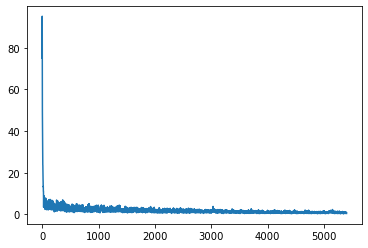

In [14]:
plt.plot(losses2)
plt.show()

In [15]:
#compute the SSIM score for every image after a feedforward propagation through 
#the network.
#Subtract the image SSIM score before the feedforward prop to obtain the net improvement for every image.
#Print the average improvement and the average SSIM score after the reconstruction.
SSIM_improvement = []
SSIM_score = []
MSE_improvement = []
MSE_score = []
NRMSE_improvement = []
NRMSE_score = []
MIE_improvement = []
MIE_score = []
for i in range(0,len(val_dataset)):
    gt, image = val_dataset[i]
    #image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    image = image.unsqueeze(0)
    gt = gt.unsqueeze(0).numpy()
    output = network_8fold(image)
  #  output = output.squeeze(1).cpu().detach().numpy()
    output = output.squeeze(1).detach().numpy()
    image = image.squeeze(1).numpy()
    gt =  np.squeeze(gt)
    output =  np.squeeze(output)
    image =  np.squeeze(image)


    output_loss1 = torch.tensor(ssim(gt, output))
    output_loss2 = torch.tensor(mse(gt, output))
    output_loss3 = torch.tensor(nrmse(gt, output))
    output_loss4 = np.mean(np.abs(gt - output))
  #  image_loss = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    image_loss1 = torch.tensor(ssim(gt, image))
    image_loss2 = torch.tensor(mse(gt, image))
    image_loss3 = torch.tensor(nrmse(gt, image))
    image_loss4 = np.mean(np.abs(gt - image))
    SSIM_improvement.append(output_loss1.item()-image_loss1.item())
    SSIM_score.append(output_loss1.item())
    MSE_improvement.append(output_loss2.item()-image_loss2.item())
    MSE_score.append(output_loss2.item())
    NRMSE_improvement.append(output_loss3.item()-image_loss3.item())
    NRMSE_score.append(output_loss3.item())
    MIE_improvement.append(output_loss4 -image_loss4)
    MIE_score.append(output_loss4)

print(np.nanmean(SSIM_improvement))
print(np.nanmean(SSIM_score))
print(np.nanmean(MSE_improvement))
print(np.nanmean(MSE_score))
print(np.nanmean(NRMSE_improvement))
print(np.nanmean(NRMSE_score))
print(np.nanmean(MIE_improvement))
print(np.nanmean(MIE_score))

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


0.2857608308562643
0.48402632195149414
-0.005673370892505269
0.0020890180045662677
-1.180884773506986
1.2306908699573498
-0.05258722
0.017924905


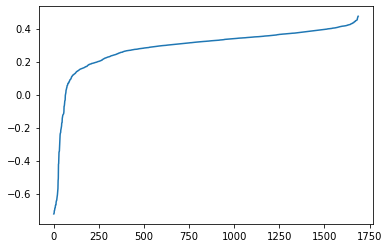

In [16]:
SSIM_improvement.sort()
plt.plot(SSIM_improvement)

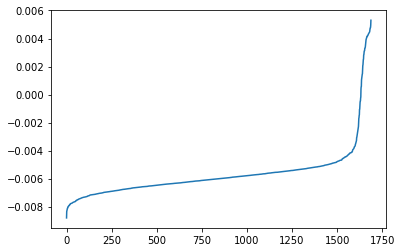

In [17]:
MSE_improvement.sort()
plt.plot(MSE_improvement)

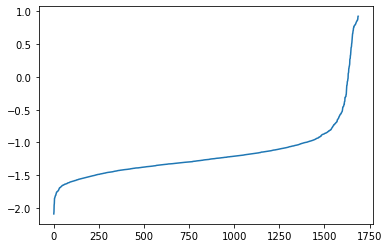

In [18]:
NRMSE_improvement.sort()
plt.plot(NRMSE_improvement)

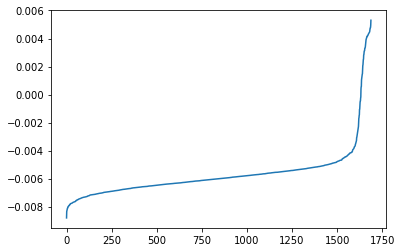

In [19]:
MIE_improvement.sort()
plt.plot(MSE_improvement)

## save Model

In [20]:
index = 11

In [21]:
#output_dir = f"s3://savemodels/network_8fold/restnet-model{index}.pt"
output_dir = f"./network_8fold/restnet-oasis-model{index}.pt"

In [22]:
#save model to S3 bucket or data
torch.save(network_8fold.state_dict(), output_dir)
#torch.save(network_8fold.state_dict(), './models/resnet18-model.pt')

## Load Model from saved model

In [ ]:
index = 10

In [ ]:
#output_dir = f"s3://savemodels/network_8fold/restnet-model{index}.pt"
output_dir = f"./network_8fold/restnet-oasis-model{index}.pt"

In [ ]:
#load model on CPU: laptop
device = torch.device('cpu')
#model = TheModelClass(*args, **kwargs)
model = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
#model.load_state_dict(torch.load(PATH, map_location=device))
model.load_state_dict(torch.load(output_dir, map_location=device))
model.eval()

## Predict a single image

In [ ]:
index = 9

In [ ]:
#model_dir = f"s3://savemodels/network_8fold/restnet-model{index}.pt"
model_dir = f"./network_8fold/restnet-oasis-model{index}.pt"

In [ ]:
#load model on CPU: laptop
device = torch.device('cpu')
#model = TheModelClass(*args, **kwargs)
model = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
#model.load_state_dict(torch.load(PATH, map_location=device))
model.load_state_dict(torch.load(model_dir, map_location=device))
model.eval()

In [ ]:
#compute the SSIM score for every image after a feedforward propagation through 
#the network.
#Subtract the image SSIM score before the feedforward prop to obtain the net improvement for every image.
#Print the average improvement and the average SSIM score after the reconstruction.
SSIM_improvement = []
SSIM_score = []
MSE_improvement = []
MSE_score = []
MIE_improvement = []
MIE_score = []
for i in range(0,len(val_dataset)):
    gt, image = val_dataset[i]
    #image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    image = image.unsqueeze(0)
    gt = gt.unsqueeze(0).numpy()
    output = model(image)
  #  output = output.squeeze(1).cpu().detach().numpy()
    output = output.squeeze(1).detach().numpy()
    image = image.squeeze(1).numpy()
    gt =  np.squeeze(gt)
    output =  np.squeeze(output)
    image =  np.squeeze(image)


    output_loss1 = torch.tensor(ssim(gt, output))
    output_loss2 = torch.tensor(mse(gt, output))
    output_loss3 = np.mean(np.abs(gt - output))
  #  image_loss = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    image_loss1 = torch.tensor(ssim(gt, image))
    image_loss2 = torch.tensor(mse(gt, image))
    image_loss3 = np.mean(np.abs(gt - image))
    SSIM_improvement.append(output_loss1.item()-image_loss1.item())
    SSIM_score.append(output_loss1.item())
    MSE_improvement.append(output_loss2.item()-image_loss2.item())
    MSE_score.append(output_loss2.item())
    MIE_improvement.append(output_loss3 -image_loss3)
    MIE_score.append(output_loss3)

print(np.nanmean(SSIM_improvement))
print(np.nanmean(SSIM_score))
print(np.nanmean(MSE_improvement))
print(np.nanmean(MSE_score))
print(np.nanmean(MIE_improvement))
print(np.nanmean(MIE_score))

In [ ]:
SSIM_improvement.sort()
plt.plot(SSIM_improvement)

In [ ]:
MSE_improvement.sort()
plt.plot(MSE_improvement)

In [ ]:
MIE_improvement.sort()
plt.plot(MSE_improvement)

In [42]:
from PIL import Image

In [8]:
file_dir = "dataBrain/OAS1_0365_MR1_mpr-1_anon_sag_66.png"

In [ ]:
im_frame = Image.open(file_dir)
   
noise_im_frame = noise_and_kspace(im_frame)

preprocess = T.Compose([
                       # T.Grayscale(num_output_channels=1),
                           T.Resize(64),    #128 as maximum
                           T.CenterCrop(64),
                           T.ToTensor() #,
                           #T.Normalize(
                            #        mean=[0.485, 0.456, 0.406],
                               #        std=[0.229, 0.224, 0.225]
                             ##         )
                            ])
img_gt = preprocess(Image.fromarray(np.uint8(im_frame)).convert('L'))
img_und = preprocess(Image.fromarray(np.uint8(noise_im_frame)).convert('L'))
    
n1 = (img_und**2).sum(dim=-1).sqrt()
norm = n1.max() 
if norm < 1e-6: norm = 1e-6
    
img_gt, img_und = img_gt/norm , img_und/norm  
    




In [12]:
from skimage.metrics import structural_similarity as cmp_ssim 
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return cmp_ssim(
        gt, pred, multichannel=True, data_range=gt.max()
    )

In [ ]:

img_und = img_und.unsqueeze(0)
output = model(img_und)
   # output = output.squeeze(1).cpu().detach().numpy()
output = output.squeeze(1).detach() #.numpy()   #image under numpy form


In [ ]:
output.shape

In [ ]:
np_rescontruct_image =  output # np.reshape(output, (64, 64))# image noise numpy array
im_reconstruct = T.ToPILImage()(np_rescontruct_image)#Image.fromarray(np_rescontruct_image).convert('L')
im_reconstruct.save("testing/test.png") #for prediction values
im_reconstruct.save("pred1.png")

In [ ]:
display(im_reconstruct)

In [ ]:
display(im_frame)

In [ ]:
display(Image.fromarray(np.uint8(noise_im_frame)))